In [1]:
import nltk
import feedparser
import ssl
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#!pip install -U scikit-learn  should not be needed  but just in case uncomment
#from nltk.corpus import stopwords


'''there is a limit in azure notebooks with NLTK in that it does not save the downloaded NLTK libs we need to cache locally
this means we need to uncomment the very next statement and the sequence of commands will be
d   - that tell the downloader you want to download something
when it prompts again enter punkt - the tokenizer 
then it will prompt again for another action
enter d to run another download
enter stopwords and then return
finally, at the last step, enter q and hit return to exit. you can now run as long as your notebook session is alive to
please add the comment, or enter a q if the prompt appears on a subsequent run'''
#nltk.download() #uncomment is you need to download stopwords, punkt, treebank
!python -m nltk.downloader punkt
!python -m nltk.downloader stopwords
!python -m nltk.downloader treebank

from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer 

stopset = set(stopwords.words('english'))  #for now use english jw 1/3/18
stopset.add('...') 
print('passed')

/home/nbuser/anaconda3_501/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/home/nbuser/anaconda3_501/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/home/nbuser/anaconda3_501/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(m

In [2]:
#just in case as this does occasionally interfere but don't just point to any URL - make sure of the source
if hasattr(ssl,'_create_unverified_context'):
    ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
docs  = [] #docs will hold a list of documents per sweep over a rss feed
docn  = 0 #this counts documents which is one to one with n.description entries found
sentn = 0 #this counts sentences within a document so you can think of a document as a list of sentences

In [4]:
#will statically load the docs list with items from a previous run
docs = ['recently, one customer said his asp.net core application used to work very well in oauth authentication all the time, but after he placed a reverse proxy in front of the web application, the authentication fails because of invalid callback path. normally speaking, a callback path is needed when registering an application to the oauth server....', 
        'in this post, premier developer consultant joe healy identifies a possible error you may get when working with an android project on xamarin forms. read about his discovery and eventual solution to fix the ssl/tls implementation issue. recently, i was helping a client with an azure active directory integrated project (adal not msal for some...', 
        'sql server management object smo) is one of the widely used way to interact with sql server due to its feature for directly able to execute mass operation as well as management operation on sql server, instead of old school way of using queries. however when using it , it should also need to be...', 
        "“if you have nothing to say, say nothing.” -- mark twain twain was so smart. i've returned to post after a long, self-imposed break from blogging, as so many great folks inside\xa0 the company work as part of their day jobs several of the areas of interest i've covered on my blog. over the last...", 
        'in this post, app dev manager john abele explores micro-frontend design with asp.net core and mvc. many development teams have spent the last few years organizing and empowering cross-functional teams, building independently managed microservices, and implementing devops pipelines to go faster than ever! these industry shifts, critical for organizations to plan less and react more,...', 
        'php_ini_system level settings cannot be changed from .user.ini or ini_set function. to make change for php_ini_system settings on azure web app, follow the steps, 1. add an app setting to your web app with the key php_ini_scan_dir and value d:homesiteini 2. create an settings.ini file using kudu console (http://&#60;site-name&#62;.scm.azurewebsite.net) in the d:homesiteini directory. 3. add...', 
        "i don't spend a lot of time talking to customers about physical data center security. as a developer using mostly paas or iaas compute platforms, i just assumed that that cloud provider had taken care of it. helping customers with data security (data at rest, data in transit, secure compute), and application code security takes...", 
        'here are top stories we found in our streams this week related to devops, vsts, tfs and other interesting topics. top stories change image size in vsts wiki - jeff bramwellif you’ve been making use of the wiki feature within vsts then you already know how useful it is for providing documentation, notes, etc. in...', 
        'when managing a self-service knowledge base, understanding how customers and employees are searching for and consuming self-service knowledge is an important part of ensuring your content remains relevant and useful for end users. dynamics includes a number of in-built capabilities to help analyze the usage of the knowledge base, including: tracking of article views by...', 
        'Azure Automation For Azure IAAS enthusiasts, Microsoft has provided a platform to automate all the azure services using powershell. The language is tweaked and used as “powershell workflow”. Why to Use Reducing Manual Effort and help in consistent testing Managing resources (deployment/VM’s etc) How to Use Create a powershell workflow in azure web portal and',
        'new titles are coming soon to the microsoft press store! buy now to save 40% on pre-order books or ebooks: https://www.microsoftpressstore.com/store/browse/coming-soon. note: new titles become available for pre-order 90 days prior to availability. some books in the image above will become available during the duration of the sale.',
       'Ransomware attacks are no longer restricted to only deletion of data but are starting to look at attacking backups as well. Taking a backup is only the first step in your protection, it becomes important to safe guard those backups too. This week as we celebrate World Backup Day, let’s look at the key considerations that customers should look for in backup products as they build the defenses to secure their backups from evolving ransomware attacks.',
       'it service management (itsm) tools help large it organizations route and handle service issues and requests. itop is an open source itsm tool written in php. it uses mysql as the backend database. in this blog, i will walk through the steps of installing itop in an azure web app and configure azure active directory']

In [5]:
#test zone to cleanup and remove punctuation from the original documents - leaves us wiht a list of strings with each
#string containing the origninal text stripped of stopwords, punctuation, and small words ( 2 char or less)
keepset = ('AI','ai','PI','pi','Pi') #small words worth keeping

#print(token in stopset)
#print(len(token)>2 or token.lower() in keepset)
atdoc=0 #track our doc location in the docs list
tstdocs = []
for doc in docs:
    #tokens  = nltk.word_tokenize(doc)      #original working version
    tokens  = nltk.wordpunct_tokenize(doc) #3/15 just to see how it works
    cleanup = [token.lower() for token in tokens if token not in stopset and ( len(token)>2 or token in keepset) ]
    #rawtext = nltk.Text(cleanup)
    #print(type(docs[0]))
    #print(type(rawtext))
    #print(cleanup)
    cleanup = ' '.join(cleanup)
    docs[atdoc] = cleanup #see if this works 3/15
    atdoc = atdoc+1
    tstdocs.append(cleanup) 

    
docn = len(docs)
print('\n number of docs is ',docn)
print(docs[0],'\n',docs[docn-1])
#print(tstdocs)



 number of docs is  13
recently one customer said asp net core application used work well oauth authentication time placed reverse proxy front web application authentication fails invalid callback path normally speaking callback path needed registering application oauth server .... 
 service management itsm tools help large organizations route handle service issues requests itop open source itsm tool written php uses mysql backend database blog walk steps installing itop azure web app configure azure active directory


In [6]:
count_vect = CountVectorizer()
counts = count_vect.fit_transform(docs)     #counts is a sparse matrix
dfcv   = pd.DataFrame(counts.toarray(),columns=count_vect.get_feature_names() )    #new 3/15
counts_rows,counts_cols = counts.get_shape()
print('counts shape: rows,cols ',counts_rows,counts_cols)
#print('counts first entry[0][0] ',counts[0,0:counts_cols])                      #get all the flags for the first document for all words in vocabularly

featnames = count_vect.get_feature_names()
print('feature locs for azure and books are :\n',featnames.index('azure'),'\t',featnames.index('books'))
print('feature names:\n',featnames[20],'\t',featnames[26])
print(dfcv.loc[0:1])

counts shape: rows,cols  13 339
feature locs for azure and books are :
 22 	 32
feature names:
 availability 	 backups
   abele  able  active  adal  add  already  also  analyze  android  app  \
0      0     0       0     0    0        0     0        0        0    0   
1      0     0       1     1    0        0     0        0        1    0   

   ...    wiki  within  work  workflow  working  world  written  www  xamarin  \
0  ...       0       0     1         0        0      0        0    0        0   
1  ...       0       0     0         0        1      0        0    0        1   

   years  
0      0  
1      0  

[2 rows x 339 columns]


In [7]:
tfidf = TfidfTransformer()
tfarray=tfidf.fit_transform(count_vect.fit_transform(docs)).toarray()
#original min_df=1 - let's try 2 and notice the changes downstream
sklearn_tfidf = TfidfVectorizer(norm='l2',min_df=1, use_idf=True, smooth_idf=False, stop_words=stopwords.words('english'), \
                                sublinear_tf=True,ngram_range=(1,1))
sklearn_representation = sklearn_tfidf.fit_transform(docs)
skarray = sklearn_representation.toarray()

#print('first doc features skarray \n ', sklearn_representation.toarray()[0].tolist()) 
#print('first doc features tfarray\n', tfarray[0].tolist())

feats = sklearn_tfidf.get_feature_names() # same as CountVectorizer
print(feats[20],'\t',feats[26])
#print(tfarray.shape)
#print(type(tfarray))
#np.set_printoptions(precision=6,suppress=True)
#print(type(tfarray[0,0]))
wordloc = 20 #oauth is loacted at that index location
wordloc2= 26 #server is located here
#these will work when df_min is 1 and ngram_range is 1,1 or 1,2 etc. currently set at (2,2) 3/14 Noon
print('\n---------------now let''s look at one word across the ',docn, ' docs---the word is azure---')
#print(tfarray[0:,wordloc].tolist())                                   #show the nth word in wordtoloc
print(skarray[0:,wordloc].tolist())
print('\n---------------now let''s look another word across the ',docn,' docs---the word is books--')
#print(tfarray[0:,wordloc2].tolist()) 
print(skarray[0:,wordloc2].tolist())

print('\nnote that server shows up in two documents and oauth in one, and look at the values - indicative of the frequencies \
as oauth appears several times in docs[9] and books appears in docs[10]')

availability 	 backups

---------------now lets look at one word across the  13  docs---the word is azure---
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14912862892501946, 0.0, 0.0]

---------------now lets look another word across the  13  docs---the word is books--
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3171104605382547, 0.0]

note that server shows up in two documents and oauth in one, and look at the values - indicative of the frequencies as oauth appears several times in docs[9] and books appears in docs[10]


In [8]:
#how let's look for something else - what docs have words in common
#a simple translation is to compare the two arrays of 337 entries for hits where a hit is simply that both are non-zero
#for example the intersection array of tfarray[0,:] and tfarray[1,:] where both values are > 0.0
#pandas dataframes
df = pd.DataFrame(sklearn_representation.toarray(),columns=feats)
#print(df['twain'],'\n',df['developer'])


In [9]:
print(sklearn_representation.todense().round(4))

[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.1407 ... 0.     0.1746 0.    ]
 [0.     0.171  0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.1491 0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.143  ... 0.     0.     0.    ]]


In [10]:
print(df.loc[0:1])

   abele  able    active      adal  add  already  also  analyze   android  \
0    0.0   0.0  0.000000  0.000000  0.0      0.0   0.0      0.0  0.000000   
1    0.0   0.0  0.140672  0.174626  0.0      0.0   0.0      0.0  0.174626   

   app  ...    wiki  within      work  workflow   working  world  written  \
0  0.0  ...     0.0     0.0  0.140923       0.0  0.000000    0.0      0.0   
1  0.0  ...     0.0     0.0  0.000000       0.0  0.174626    0.0      0.0   

   www   xamarin  years  
0  0.0  0.000000    0.0  
1  0.0  0.174626    0.0  

[2 rows x 334 columns]


In [11]:
#print(df['server'] > 0.1)
#print(df.loc[0:1].corr())
#print(df.loc[0:1].cov())
#print((df.corrwith(df.loc[1])))
#print(df.loc[0].value_counts())
df.describe()




,abele,able,active,adal,add,already,also,analyze,android,app,...,wiki,within,work,workflow,working,world,written,www,xamarin,years
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.012446,0.013157,0.021824,0.013433,0.020014,0.013154,0.013157,0.012902,0.013433,0.035222,...,0.022272,0.013154,0.022226,0.022950,0.013433,0.011623,0.013658,0.011471,0.013433,0.012446
std,0.044876,0.047438,0.053273,0.048432,0.072160,0.047429,0.047438,0.046520,0.048432,0.071454,...,0.080304,0.047429,0.054272,0.082746,0.048432,0.041909,0.049246,0.041361,0.048432,0.044876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.161804,0.171042,0.143036,0.174626,0.260177,0.171007,0.171042,0.167731,0.174626,0.223103,...,0.289539,0.171007,0.148012,0.298346,0.174626,0.151105,0.177559,0.149129,0.174626,0.161804


In [12]:
print(df.loc[0])

abele             0.000000
able              0.000000
active            0.000000
adal              0.000000
add               0.000000
already           0.000000
also              0.000000
analyze           0.000000
android           0.000000
app               0.000000
application       0.295742
areas             0.000000
article           0.000000
asp               0.140923
assumed           0.000000
attacking         0.000000
attacks           0.000000
authentication    0.296192
automate          0.000000
automation        0.000000
availability      0.000000
available         0.000000
azure             0.000000
azurewebsite      0.000000
backend           0.000000
backup            0.000000
backups           0.000000
base              0.000000
become            0.000000
becomes           0.000000
                    ...   
twain             0.000000
tweaked           0.000000
understanding     0.000000
usage             0.000000
use               0.000000
used              0.121026
u

In [13]:
import matplotlib.pyplot as plt
#plt.plot(df.loc[0])
df.loc[0].plot(figsize=(15,9))

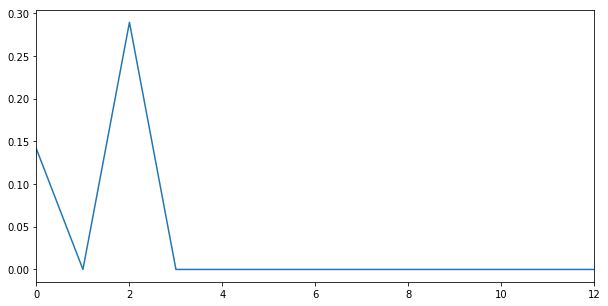

In [14]:
df['server'].plot(figsize=(10,5))

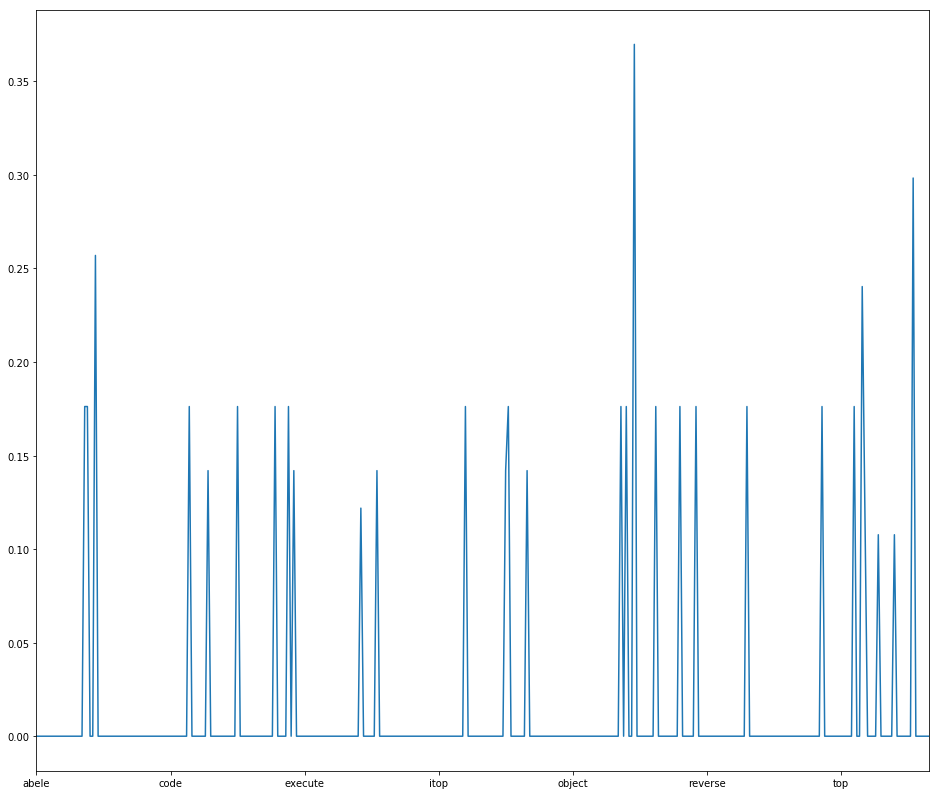

In [15]:
(df.loc[9]).plot(figsize=(16,14))

In [16]:
df2 = ( (df.loc[0] > 0.0) &  (df.loc[1] > 0.0))
print(df2.describe(),'\n\n')
print(df2[df2 == True])

count       334
unique        2
top       False
freq        333
dtype: object 


recently    True
dtype: bool


In [17]:
#should only do this with counts - not fractionial for dotproducts
print('dot product: ',df.loc[0].dot(df.loc[1])) #dot prodcut shows strenght of common words across two document vectors
dff = df.loc[0].T
print('dot product: ',dff.dot(df.loc[2]))
#print('this says that docs 0 and 2 are more alike than docs 0 and 1')

dot product:  0.01982391791754074
dot product:  0.08880841160757086


In [18]:
print('0: ',docs[0],'\n\n1: ',docs[1],'\n\n2:',docs[2])

0:  recently one customer said asp net core application used work well oauth authentication time placed reverse proxy front web application authentication fails invalid callback path normally speaking callback path needed registering application oauth server .... 

1:  post premier developer consultant joe healy identifies possible error may get working android project xamarin forms read discovery eventual solution fix ssl tls implementation issue recently helping client azure active directory integrated project adal msal 

2: sql server management object smo one widely used way interact sql server due feature directly able execute mass operation well management operation sql server instead old school way using queries however using also need


In [19]:
#let's use the above to make a simple latent semantic index model (LSI)
!pip install -q gensim 
from gensim import corpora, models
#docs has our collection of documents and lets make that a dictionary - input needs to be array of tokens
#mydictokens = [doc for doc in nltk.word_tokenize(docs)]
mydictokens = [nltk.word_tokenize(doc) for doc in docs]
#print((mydictokens))
dictionary  = corpora.Dictionary(mydictokens)
#print(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in mydictokens]
#print(corpus)
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]
# fix the number of topics total_topics =n  using 3 for demos and stuff but changing it around is very illustrative
total_topics = 4 #default is 3

lsi = models.LsiModel(corpus_tfidf, id2word=dictionary,  num_topics=total_topics)
for index, topic in lsi.print_topics(total_topics):
    print ('Topic #'+str(index+1))
    print (topic) 


Topic #1
0.201*"azure" + 0.168*"service" + 0.157*"powershell" + 0.148*"itop" + 0.148*"itsm" + 0.136*"app" + 0.128*"application" + 0.127*"settings" + 0.123*"knowledge" + 0.119*"web"
Topic #2
-0.247*"data" + -0.220*"security" + -0.214*"application" + -0.147*"path" + -0.147*"callback" + -0.147*"oauth" + -0.147*"authentication" + -0.147*"compute" + 0.139*"azure" + -0.137*"server"
Topic #3
-0.235*"knowledge" + 0.170*"sql" + -0.161*"look" + -0.161*"backup" + -0.161*"backups" + 0.160*"server" + -0.159*"self" + -0.157*"base" + -0.149*"data" + -0.128*"service"
Topic #4
-0.182*"twain" + -0.182*"nothing" + -0.182*"say" + -0.165*"teams" + 0.159*"data" + 0.149*"powershell" + 0.136*"security" + -0.127*"last" + -0.127*"many" + 0.109*"backup"


What's going on above. briefly, for each topic listed there is an associated set of words that have been calculated as being associated with that topic. if we ignore the weighting and signs the words, should, appear to map to a parent topic, even if that topic have not been given a name. For example, when running the above selecting for 3 topics (and using the original corpus), the first topic has words like [application, data, security,azure,oauth]. it is not surprising to see those words being used in a single document. The second topic has words like [data, security,backup,backups,app]. Perhaps not as easy to map as the first topic but not uncommon. Topic #3 has terms as [knowledge, sql, base, service, operation]. that's a bit harder to make sense of direclty, but now let's look at the weights. Overall, higher weights and same sign indicate words that are correlated with respect to the topic. In Topic #1 all the weights are + and between 0.133 and 0.179, so they are all correlated and all at about the same level. In Topic #2, the weights and signs are more varied meaning that "data" and "security" in topic #2 are correlated in the same 'direction', but "settings" and "app" are correlated but in a different direction. Also, the weights of "data" and "security" are relatively higher than other weights. if we go back to our corpus of 12 documents and review them we do see one document in particular where data and backup(s) are mentioned several times in just a few sentences. But, there may be an easier way to handle this. The idea for the next block of code is from, "Text Analytics  with Python", by Dipanjan Sarkar, published by Apress.


As an experiement - see how the results vary by number of topics. while this sample has only 12 or 13 documents they tend to come from the same general source (tech blogs) but within the source can be spread out over several areas - developer, data, datascience, infrastrucutre etc.

In [20]:
#note the use of weight threshold and limiting the number of terms to include to make the outputs a bit simpler
def print_topics_gensim(topic_model, total_topics=1, weight_threshold=0.0001,   display_weights=True,   num_terms=None):
    for index in range(total_topics):        
        topic = topic_model.show_topic(index)        
        topic = [(word, round(wt,2))                 
                 for word, wt in topic                 
                 if abs(wt) >= weight_threshold]        
        if display_weights:            
            print ('Topic #'+str(index+1)+' with weights')            
            print (topic[:num_terms] if num_terms else topic)        
        else:            
            print ('Topic #'+str(index+1)+' without weights')            
            tw = [term for term, wt in topic]            
            print (tw[:num_terms] if num_terms else tw)        
        print('')


In [21]:
print_topics_gensim(lsi,total_topics,weight_threshold=0.001,num_terms=7)

Topic #1 with weights
[('azure', 0.2), ('service', 0.17), ('powershell', 0.16), ('itop', 0.15), ('itsm', 0.15), ('app', 0.14), ('application', 0.13)]

Topic #2 with weights
[('data', -0.25), ('security', -0.22), ('application', -0.21), ('path', -0.15), ('callback', -0.15), ('oauth', -0.15), ('authentication', -0.15)]

Topic #3 with weights
[('knowledge', -0.24), ('sql', 0.17), ('look', -0.16), ('backup', -0.16), ('backups', -0.16), ('server', 0.16), ('self', -0.16)]

Topic #4 with weights
[('twain', -0.18), ('nothing', -0.18), ('say', -0.18), ('teams', -0.17), ('data', 0.16), ('powershell', 0.15), ('security', 0.14)]



Feel free to experiment with number of topics, terms, and thresholds to see how the topic modeling is impacted. Also, it is a great exercise to add more content to the orginal document array back in the fourth cell.

In [22]:
#now - try out latent dirichlet allocation model
#to use this we need our TFIDF calculated above, number of topics to model
#first - create an LDA model and then invoke/fit that model using the TFIDF - using gensim module
#set up work to get things structured for input
#need a normalized corpus - we have that - corpus
#need a dictionary of the corpus - have that - dictionary 
#need a TFIDF of the corpus - have that - corpus_tfidf
lda_gensim = models.LdaModel(corpus_tfidf,id2word=dictionary,iterations=100,num_topics=4)
print(lda_gensim)

print_topics_gensim(lda_gensim,total_topics,weight_threshold=0.001,num_terms=7)

LdaModel(num_terms=347, num_topics=4, decay=0.5, chunksize=2000)
Topic #1 with weights
[('teams', 0.01), ('mvc', 0.0), ('micro', 0.0), ('development', 0.0), ('frontend', 0.0), ('functional', 0.0), ('shifts', 0.0)]

Topic #2 with weights
[('azure', 0.01), ('vsts', 0.01), ('powershell', 0.01), ('settings', 0.01), ('nothing', 0.01), ('twain', 0.01), ('say', 0.01)]

Topic #3 with weights
[('knowledge', 0.01), ('sql', 0.01), ('project', 0.01), ('server', 0.01), ('base', 0.01), ('way', 0.01), ('operation', 0.01)]

Topic #4 with weights
[('data', 0.01), ('security', 0.01), ('backup', 0.01), ('look', 0.01), ('backups', 0.01), ('compute', 0.01), ('ransomware', 0.01)]

